## Evaluate CNTK Fast-RCNN model directly from python

This notebook demonstrates how to evaluate a single image using a CNTK Fast-RCNN model.

For a full description of the model and the algorithm, please see the following <a href="https://docs.microsoft.com/en-us/cognitive-toolkit/Object-Detection-using-Fast-R-CNN" target="_blank">tutorial</a>.

Below, you will see sample code for:
1. Preparing the input data for the network (including image size adjustments)
2. Evaluation of the input data using the model
3. Processing the evaluation result and presenting the selected regions back on the image.

<b>Important</b>: Before running this notebook, please make sure that:
<ol>
<li>You have version >= 2.0 RC 1 of CNTK installed. Installation instructions are available <a href="https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-CNTK-on-your-machine" target="_blank">here</a>.

<li>This notebook uses the CNTK python APIs and should be run from the CNTK python environment.</li>

<li>OpenCV and the other required python packages for the Fast-RCNN scenario are installed. Please follow the instructions <a href="https://docs.microsoft.com/en-us/cognitive-toolkit/Object-Detection-using-Fast-R-CNN#setup" target="_blank">in here</a> to install the required packages.
</ol>

##### 1. Download the sample dataset and make sure that the model exists
First things first - we will download the sample Grocery dataset (if it's not already there), and we'll also make sure that the Fast-RCNN model file exists. The script will use your local trained model (if available), or will download and use the pre-trained model if a local trained model isn't available.
In case we run inside the CNTK test enviornment, the model and data are copied from the test data directory.
We also set the device to cpu / gpu for the test environment. If you have both CPU and GPU on your machine, you can optionally switch the devices. By default, we choose the best available device.

In [1]:
%matplotlib inline
# the above line enable us to draw the images inside the notebooks

import os
import sys
from os import path
import cntk

# Check for an environment variable defined in CNTK's test infrastructure
def is_test(): return 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY' in os.environ


# Select the right target device when this notebook is being tested
# Currently supported only for GPU 
# Setup data environment for pre-built data sources for testing
if is_test(): 
    if 'TEST_DEVICE' in os.environ:
        if os.environ['TEST_DEVICE'] == 'cpu':
            cntk.device.try_set_default_device(cntk.device.cpu()) 
        else:
            cntk.device.try_set_default_device(cntk.device.gpu(0))
    sys.path.append(os.path.join(*"../../../../Tests/EndToEndTests/CNTKv2Python/Examples".split("/")))
    import prepare_test_data as T
    T.prepare_Grocery_data()
    T.prepare_fastrcnn_grocery_100_model()

#Make sure the grocery dataset is installed 
sys.path.append('../../DataSets/Grocery')
from install_grocery import download_grocery_data
download_grocery_data()

# Make sure the FRCNN model exists - check if the model was trained and exists, if not - download the existing model

sys.path.append('../../PretrainedModels')
from models_util import download_model_by_name
download_model_by_name("Fast-RCNN_grocery100")
model_path = '../../PretrainedModels/Fast-RCNN_grocery100.model'


Data already available at /home/nadavbar/code/CNTK/Examples/Image/DataSets/Grocery/../Grocery
CNTK model already available at /home/nadavbar/code/CNTK/Examples/Image/PretrainedModels/Fast-RCNN_grocery100.model


### 3. load the model and prepare it for evaluation:
As a first step for using the Fast-RCNN model, we load the trained model file.

The trained model accepts 3 inputs: The image data, the bounding box (region of interest, or ROI) proposals and the ground truth labels of the ROIs. Since we are evaluating a new image - we probably don't have the ground truth labels for the image, hence - we need to adjust the network to accept  only the image and the ROIs as input.
In order to do that we use the CNTK APIs to clone the network and change its input nodes.

More information and examples regarding cloning nodes of a network are available in the <a href="https://docs.microsoft.com/en-us/cognitive-toolkit/Build-your-own-image-classifier-using-Transfer-Learning" target="_blank">Transfer Learning</a> tutorial.

In [2]:
from cntk import load_model
from cntk import placeholder
from cntk.logging.graph import find_by_name, get_node_outputs
from cntk.ops import combine
from cntk.ops.sequence import input_variable
from cntk.ops.functions import CloneMethod

# load the trained model
trained_frcnn_model = load_model(model_path)

# find the original features and rois input nodes
features_node = find_by_name(trained_frcnn_model, "features")
rois_node = find_by_name(trained_frcnn_model, "rois")

#  find the output "z" node
z_node = find_by_name(trained_frcnn_model, 'z')

# define new input nodes for the features (image) and rois
image_input = input_variable(features_node.shape, name='features')
roi_input = input_variable(rois_node.shape, name='rois')

# Clone the desired layers with fixed weights and place holder for the new input nodes
cloned_nodes = combine([z_node.owner]).clone(
    CloneMethod.freeze,
    {features_node: placeholder(name='features'), rois_node: placeholder(name='rois')})

# apply the cloned nodes to the input nodes
frcnn_model = cloned_nodes(image_input, roi_input)

print("Fast-RCNN Grocery model loaded succesfully!")

Fast-RCNN Grocery model loaded succesfully!


### 4. Load an image and convert it to the network format

Next, we load an image from the test set using OpenCV, and then resize according to the network input dimensions. (Which are set when the network is trained).
When resizing, we preserve scale and pad the border areas with a constant value (114), which is later used for normalization by the network.

(-0.5, 999.5, 999.5, -0.5)

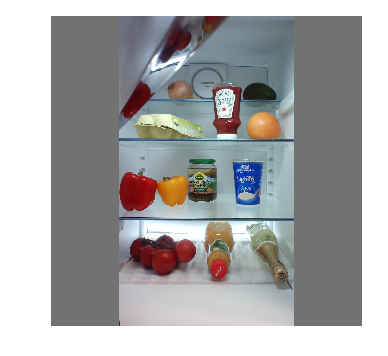

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_height = 1000
image_width = 1000 

def resize_and_pad(img, width, height, pad_value=114):
    # port of the c++ code from CNTK: https://github.com/Microsoft/CNTK/blob/f686879b654285d06d75c69ee266e9d4b7b87bc4/Source/Readers/ImageReader/ImageTransformers.cpp#L316
    img_width = len(img[0])
    img_height = len(img)
    
    scale_w = img_width > img_height
    
    target_w = width
    target_h = height
    
    if scale_w:
        target_h = int(np.round(img_height * float(width) / float(img_width)))
    else:
        target_w = int(np.round(img_width * float(height) / float(img_height)))
        
    resized = cv2.resize(img, (target_w, target_h), 0, 0, interpolation=cv2.INTER_NEAREST)
    
    top = int(max(0, np.round((height - target_h) / 2)))
    left = int(max(0, np.round((width - target_w) / 2)))
    
    bottom = height - top - target_h
    right = width - left - target_w
    
    resized_with_pad = cv2.copyMakeBorder(resized, top, bottom, left, right, 
                                          cv2.BORDER_CONSTANT, value=[pad_value, pad_value, pad_value])
        
    #tranpose(2,0,1) converts the image to the HWC format which CNTK accepts
    model_arg_rep = np.ascontiguousarray(np.array(resized_with_pad, dtype=np.float32).transpose(2,0,1))
    
    return resized_with_pad, model_arg_rep

def load_image_and_scale(image_path, width, height, pad_value=114):
    img = cv2.imread(image_path)
    return resize_and_pad(img, width, height, pad_value), img

test_image_path = r"../../DataSets/Grocery/testImages/WIN_20160803_11_28_42_Pro.jpg"
(test_img, test_img_model_arg), original_img = load_image_and_scale(test_image_path, image_width, image_height)

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

### 5. Generate ROIs for testing

Now, we produce regions of interest (ROIs) proposals using selective search & grid methods, using the same method as in the script: A1_GenerateInputROIs.py.

Each ROI is in the format of [x,y,w,h], where the coordinates real numbers in the range of 0 to 1, and scaled according to the resized and padded image. 
The ROIs array is padded with regions of [0,0,0,0] at the end to match the 2000 ROIs input format of the model.

In [4]:
# Parameters taken from PARAMETERS.py
# ROI generation
roi_minDimRel = 0.04
roi_maxDimRel = 0.4
roi_minNrPixelsRel = 2    * roi_minDimRel * roi_minDimRel
roi_maxNrPixelsRel = 0.33 * roi_maxDimRel * roi_maxDimRel
roi_maxAspectRatio = 4.0  # maximum aspect Ratio of a ROI vertically and horizontally
roi_maxImgDim = 200       # image size used for ROI generation
ss_scale = 100            # selective search ROIS: parameter controlling cluster size for segmentation
ss_sigma = 1.2            # selective search ROIs: width of gaussian kernal for segmentation
ss_minSize = 20           # selective search ROIs: minimum component size for segmentation
grid_nrScales = 7         # uniform grid ROIs: number of iterations from largest possible ROI to smaller ROIs
grid_aspectRatios = [1.0, 2.0, 0.5]    # uniform grid ROIs: aspect ratio of ROIs
cntk_nrRois = 100  # 100 # how many ROIs to zero-pad
cntk_padWidth = 1000
cntk_padHeight = 1000

from cntk_helpers import imArrayWidthHeight, getSelectiveSearchRois, imresizeMaxDim
from cntk_helpers import getGridRois, filterRois, roiTransformPadScaleParams, roiTransformPadScale

def get_rois_for_image(img, use_selective_search=True, use_grid_rois=True):
    
    roi_minDim = roi_minDimRel * roi_maxImgDim
    roi_maxDim = roi_maxDimRel * roi_maxImgDim
    roi_minNrPixels = roi_minNrPixelsRel * roi_maxImgDim*roi_maxImgDim
    roi_maxNrPixels = roi_maxNrPixelsRel * roi_maxImgDim*roi_maxImgDim


    imgOrig = img.copy()

    # get rois
    if use_selective_search:
        print ("Calling selective search..")
        rects, scaled_img, scale = getSelectiveSearchRois(imgOrig, ss_scale, ss_sigma, ss_minSize, roi_maxImgDim) #interpolation=cv2.INTER_AREA
        print ("Number of rois detected using selective search: " + str(len(rects)))
    else:
        rects = []
        scaled_img, scale = imresizeMaxDim(imgOrig, roi_maxImgDim, boUpscale=True, interpolation=cv2.INTER_AREA)
        
    imgWidth, imgHeight = imArrayWidthHeight(scaled_img)

    # add grid rois
    if use_grid_rois:
        rectsGrid = getGridRois(imgWidth, imgHeight, grid_nrScales, grid_aspectRatios)
        print ("Number of rois on grid added: " + str(len(rectsGrid)))
        rects += rectsGrid

    # run filter
    print ("Number of rectangles before filtering  = " + str(len(rects)))
    rois = filterRois(rects, imgWidth, imgHeight, roi_minNrPixels, roi_maxNrPixels, roi_minDim, roi_maxDim, roi_maxAspectRatio)
    if len(rois) == 0: #make sure at least one roi returned per image
        rois = [[5, 5, imgWidth-5, imgHeight-5]]
    print ("Number of rectangles after filtering  = " + str(len(rois)))

    # scale up to original size and save to disk
    # note: each rectangle is in original image format with [x,y,x2,y2]
    original_rois = np.int32(np.array(rois) / scale)
    
    img_width = len(img[0])
    img_height = len(img)

    # all rois need to be scaled + padded to cntk input image size
    targetw, targeth, w_offset, h_offset, scale = roiTransformPadScaleParams(img_width, img_height,
                                                               cntk_padWidth, cntk_padHeight)
    
    rois = []
    for original_roi in original_rois:
        x, y, x2, y2 = roiTransformPadScale(original_roi, w_offset, h_offset, scale)

        xrel = float(x) / (1.0 * targetw)
        yrel = float(y) / (1.0 * targeth)
        wrel = float(x2 - x) / (1.0 * targetw)
        hrel = float(y2 - y) / (1.0 * targeth)
        
        rois.append([xrel, yrel, wrel, hrel])
    
    # pad rois if needed:
    if len(rois) < cntk_nrRois:
        rois += [[0, 0, 0, 0]] * (cntk_nrRois - len(rois))
    elif len(rois) > cntk_nrRois:
        rois = rois[:cntk_nrRois]
    return np.array(rois), original_rois
    
test_rois, original_rois = get_rois_for_image(original_img)
roi_padding_index = len(original_rois)
print("Number of rois for evaluation:", len(test_rois))

--------------------------------------------------------------
Calling selective search..
Number of rois detected using selective search: 590
Number of rois on grid added: 110580
Number of rectangles before filtering  = 111170
Number of rectangles after filtering  = 1345
Number of rois for evaluation: 100


### 6. Evaluate the sample
Here, we prepare the data to be in CNTK's expected arguments format and run it through the model used the model's **eval** method.

We then process the result by trimming the padded ROIs part, and calculate the predicted labels and their probabilities.

In [5]:
from cntk_helpers import softmax2D

# a dummy variable for labels the will be given as an input to the network but will be ignored
dummy_labels = np.zeros((2000,17))

#Index the names of the arguments so we can get them by name
args_indices = {}
for i,arg in enumerate(frcnn_model.arguments):
    args_indices[arg.name] = i
    
# prepare the arguments
arguments = {
    frcnn_model.arguments[args_indices['features']]: [test_img_model_arg],
    frcnn_model.arguments[args_indices['rois']]: [test_rois],
}

# run it through the model
output = frcnn_model.eval(arguments)

# we now extract the "z" values from the output, which are the values of the layer that is just before
# the softmax layer.
# we take just the relevant part from that array 
rois_values = output[0][0][:roi_padding_index]

# get the prediction for each roi by taking the index with the maximal value in each row 
rois_labels_predictions = np.argmax(rois_values, axis=1)

# calculate the probabilities using softmax
rois_probs = softmax2D(rois_values) 

# print the number of ROIs that were detected as non-background
print("Number of detections: %d"%np.sum(rois_labels_predictions > 0))

/home/nadavbar/anaconda3/envs/cntk-py34/lib/python3.4/site-packages/cntk/core.py:330: UserWarning: your data is of type "float64", but your input variable (uid "Input225") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Number of detections: 39


### 7. Merge overlapping regions using Non-Maxima-Suppression
Before inspecting the predictions, we need to merge overlapping regions that were detected using the Non-Maxima-Suppression algorithm that is implemented in the cntk_helpers module.

In [6]:
from cntk_helpers import applyNonMaximaSuppression
nms_threshold = 0.1
non_padded_rois = test_rois[:roi_padding_index]
max_probs = np.amax(rois_probs, axis=1).tolist()
rois_prediction_indices = applyNonMaximaSuppression(nms_threshold, rois_labels_predictions, max_probs, non_padded_rois)
print("Indices of selected regions:",rois_prediction_indices)

Indices of selected regions: [0, 67, 24, 10, 75, 71, 82, 60, 39, 91]


### 8. Visualize the results

As a final step, we use the OpenCV **rectangle** and **putText** methods in order to draw the selected regions on the original image alongside their corresponding predicted labels.

Evaluation result:


(-0.5, 1079.5, 1919.5, -0.5)

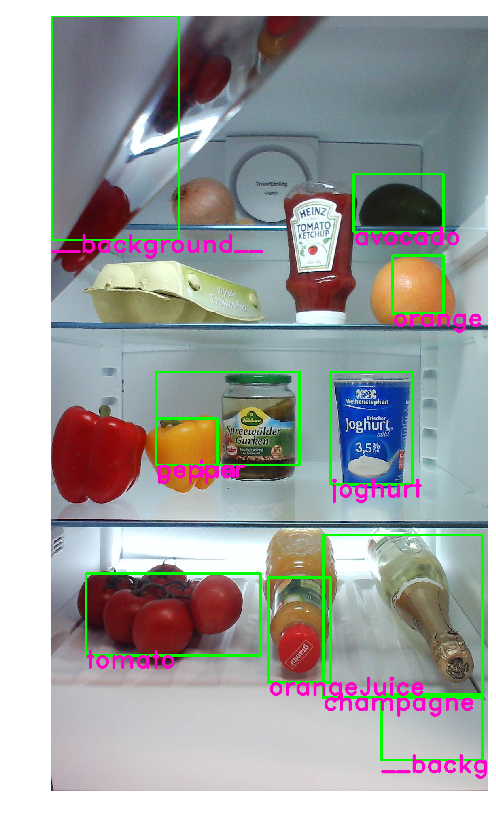

In [7]:
rois_with_prediction = test_rois[rois_prediction_indices]
rois_prediction_labels = rois_labels_predictions[rois_prediction_indices]
rois_predicion_scores = rois_values[rois_prediction_indices]
original_rois_predictions = original_rois[rois_prediction_indices]

# class names taken from PARAMETERS.py:
classes = ('__background__',  # always index 0
               'avocado', 'orange', 'butter', 'champagne', 'eggBox', 'gerkin', 'joghurt', 'ketchup',
               'orangeJuice', 'onion', 'pepper', 'tomato', 'water', 'milk', 'tabasco', 'mustard')

original_img_cpy = original_img.copy()

for roi,label in zip(original_rois_predictions, rois_prediction_labels):
    (x1,y1,x2,y2) = roi
    cv2.rectangle(original_img_cpy, (x1, y1), (x2, y2), (0, 255, 0), 5)
    cv2.putText(original_img_cpy,classes[label],(x1,y2 + 30), cv2.FONT_HERSHEY_DUPLEX, 2,(200,0,255),3,cv2.LINE_AA)

print("Evaluation result:")
plt.figure(figsize=(10, 10))    
plt.imshow(cv2.cvtColor(original_img_cpy, cv2.COLOR_BGR2RGB), interpolation='nearest')

plt.axis("off")